In [11]:
# do basic imports
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp
# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#wod cloud
from PIL import Image
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [12]:
# load data
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
imdb_data = pd.read_csv('imdb_data.csv')
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [13]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [14]:
imdb_data.head(5)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [24]:
imdb_data.dtypes

movieId            int64
title_cast        object
director          object
runtime          float64
budget            object
plot_keywords     object
dtype: object

In [17]:
#Merge train with Movies

In [18]:
train_movies = pd.merge(train, movies, on='movieId')
train_movies.head(5)

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [44]:
imdb_data.head(2)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game


In [29]:
imdb_data.dropna(inplace=True)

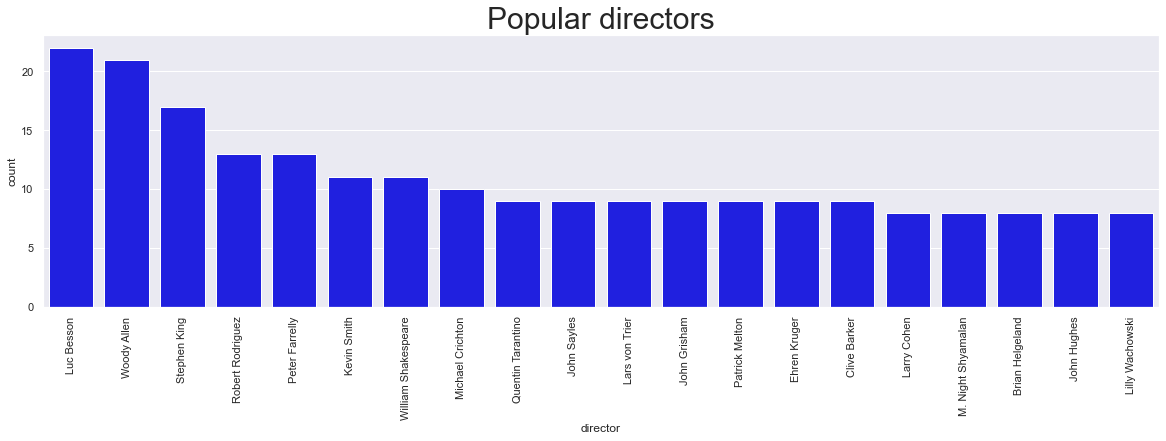

In [76]:
# Plot popular directors
plt.figure(figsize = (20,5))
directors=imdb_data['director'].explode()
ax=sns.countplot(x=directors, order = directors.value_counts().index[:20],color='blue')
ax.set_title('Popular directors',fontsize=30)
plt.xticks(rotation=90)
plt.show()

In [36]:
#create a dataframe for analysis
ratings_trend = pd.DataFrame(train_movies.groupby('movieId')['rating'].mean())
ratings_trend['total number of ratings'] = pd.DataFrame(train_movies.groupby('movieId')['rating'].count()) 
ratings_trend.head(10)

,rating,total number of ratings
movieId,,
1,3.889971,23062
2,3.263414,9654
3,3.132325,4727
4,2.878099,968
5,3.059165,4648
6,3.857906,9828
7,3.381459,4838
8,3.052209,498
9,3.010533,1519


In [18]:
#create a dataframe for analysis
new_trend = pd.DataFrame(train_movies.groupby('title')['rating'].mean())
new_trend['total number of ratings'] = pd.DataFrame(train_movies.groupby('title')['rating'].count())

In [19]:
# sort dataframe by total number of ratings
new_trend.sort_values(by=['total number of ratings'], inplace=True, ascending=False)
# reset the index
new_trend.reset_index(inplace=True)

<AxesSubplot:xlabel='total number of ratings', ylabel='title'>

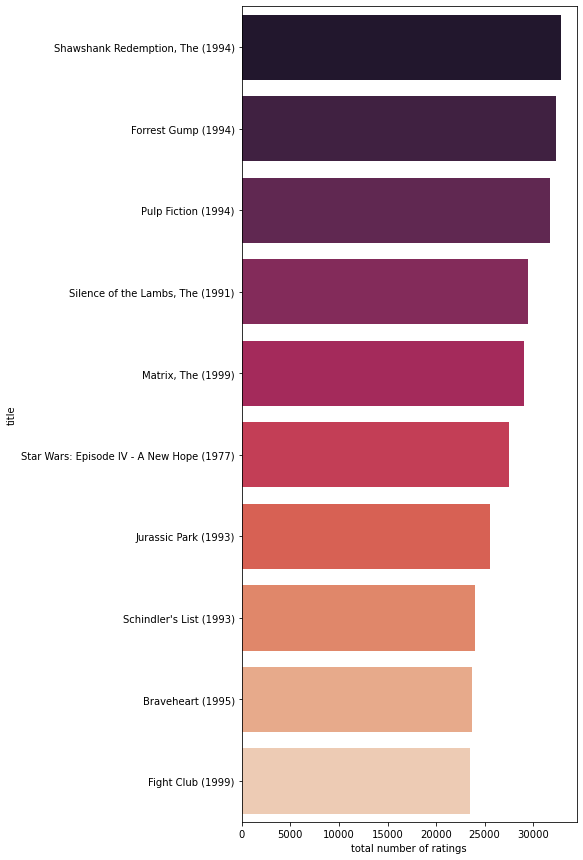

In [20]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

sns.barplot(x="total number of ratings", y="title", data=new_trend.head(10), palette='rocket')

In [56]:
# Create dataframe containing only the movieId and keywords
imdb_keywords = pd.DataFrame(imdb_data[['movieId', 'plot_keywords']],
                             columns=['movieId', 'plot_keywords'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
imdb_keywords.plot_keywords = imdb_keywords.plot_keywords.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
imdb_keywords = pd.DataFrame([(tup.movieId,d) for tup in imdb_keywords.itertuples() for d in tup.plot_keywords],
                             columns=['movieId', 'plot_keywords'])

imdb_keywords.head()

,movieId,plot_keywords
0,1,toy
1,1,rivalry
2,1,cowboy
3,1,cgi animation
4,2,board game


In [41]:
# Create dataframe containing only the movieId and title_casts
imdb_casts = pd.DataFrame(imdb_data[['movieId', 'title_cast']],
                             columns=['movieId', 'title_cast'])

# Split title_casts seperated by "|" and create a list containing the title_cast allocated to each movie
imdb_casts.title_cast = imdb_casts.title_cast.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-title_cast combination is in a seperate row
imdb_casts = pd.DataFrame([(tup.movieId, d) for tup in imdb_casts.itertuples() for d in tup.title_cast],
                             columns=['movieId', 'title_cast'])

imdb_casts.head()

,movieId,title_cast
0,1,Tom Hanks
1,1,Tim Allen
2,1,Don Rickles
3,1,Jim Varney
4,1,Wallace Shawn


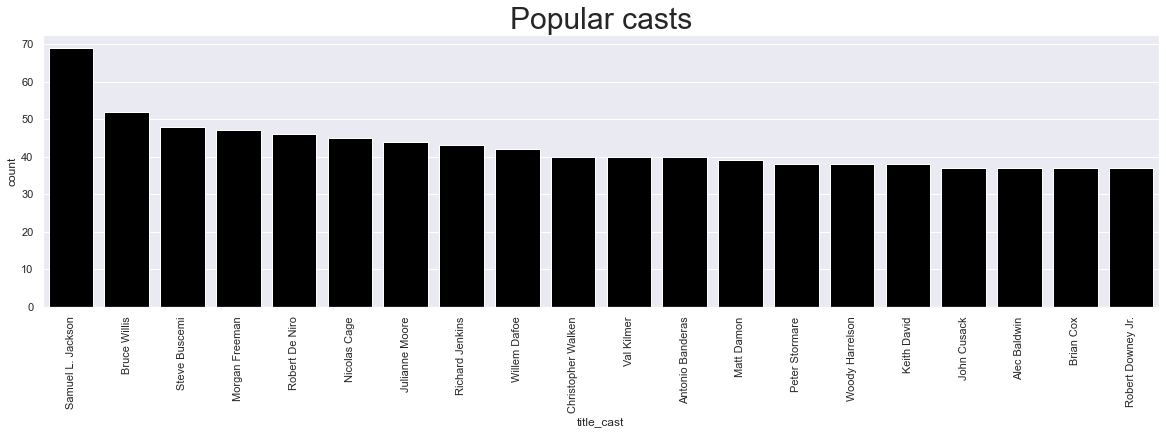

In [84]:
# Plot popular casts
plt.figure(figsize = (20,5))
casts=imdb_casts['title_cast'].explode()
ax=sns.countplot(x=casts, order = casts.value_counts().index[:20],color='black')
ax.set_title('Popular casts',fontsize=30)
plt.xticks(rotation=90)
plt.show()


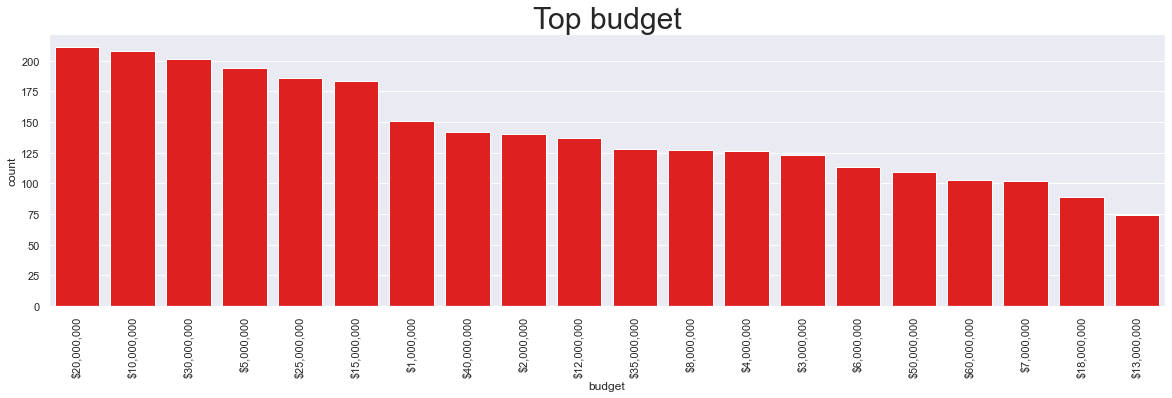

In [83]:
#budget
plt.figure(figsize = (20,5))
budget=imdb_data['budget'].explode()
ax=sns.countplot(x=budget, order = budget.value_counts().index[:20],color='red')
ax.set_title('Top budget',fontsize=30)
plt.xticks(rotation=90)
plt.show()


In [66]:
train_movies.head(2)

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [73]:
# Create dataframe containing only the movieId and keywords
new = pd.DataFrame(train_movies[['movieId', 'title']],
                             columns=['movieId', 'title'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
new .title = new .title.apply(lambda x: x.split('(|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
new  = pd.DataFrame([(tup.movieId,d) for tup in new .itertuples() for d in tup.title],
                             columns=['movieId', 'title'])

new .head()

,movieId,title
0,57669,In Bruges (2008)
1,57669,In Bruges (2008)
2,57669,In Bruges (2008)
3,57669,In Bruges (2008)
4,57669,In Bruges (2008)


In [71]:
st=new()
df=movies[['movieId','year']].groupby ('year')

fig, ax1=plt.subplots(figsize=(15,10))
ax1.plot(df.year.first(),df.movieId.nunique(),"g-o")
ax1.grid(none)
ax1.set_ylim(0,)

df=ratings[['rating','timestamp']].groupby('timestamp')
ax2=ax1.twinx()
ax2.plot(df.timestamp.first(),df.rating.count(),"r-o")
ax2.grid(none)
ax2.set_ylim(0,)

ax1.set_xlabel('year')
ax1.set_ylabel('number of movies released');ax2.st_ylabel('number of ratings')
plt.title('movies per year')
plt.show()

%reset_selective -f (^DF$|^ax1$|^ax2$)
runtime= new() - st
print ("Elapsed time(sec): ",round(runtime,2))

TypeError: 'DataFrame' object is not callable

In [67]:
imdb_data.head(2)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game


In [61]:
# Create dataframe containing only the movieId and keywords
imdb_keywords = pd.DataFrame(imdb_data[['movieId', 'plot_keywords']],
                             columns=['movieId', 'plot_keywords'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
imdb_keywords.plot_keywords = imdb_keywords.plot_keywords.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
imdb_keywords = pd.DataFrame([(tup.movieId,d) for tup in imdb_keywords.itertuples() for d in tup.plot_keywords],
                             columns=['movieId', 'plot_keywords'])

imdb_keywords.head()

,movieId,plot_keywords
0,1,toy
1,1,rivalry
2,1,cowboy
3,1,cgi animation
4,2,board game


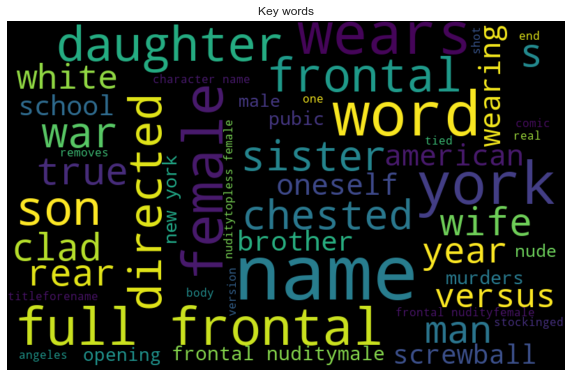

In [63]:
#word cloud for key words that people use while searching
all_words = ''.join([label for label in imdb_keywords['plot_keywords']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Key words')

plt.show()

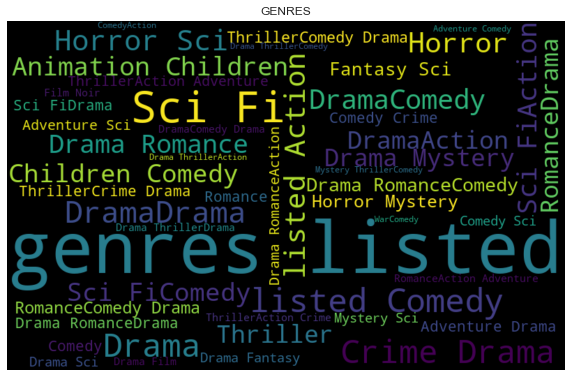

In [59]:
#word cloud for genre
#from wordcloud import WordCloud
all_words = ''.join([label for label in movies['genres']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('GENRES')

plt.show()

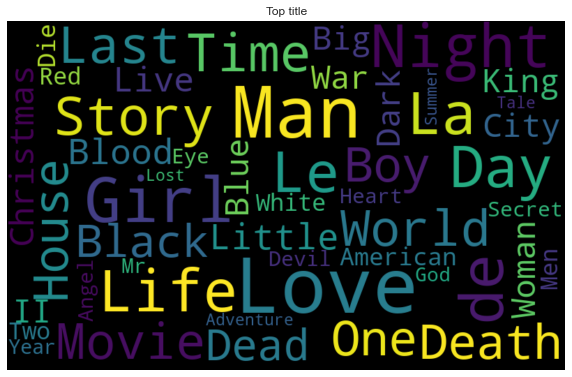

In [58]:
#word cloud for top title
from wordcloud import WordCloud
all_words = ''.join([label for label in movies['title']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top title')

plt.show()